Loaded processed data: (8760, 4), train=7008, test=1752
ARIMA predictions and residuals prepared. Residuals length: 1752
Using in-sample residuals from train for LSTM training. Length: 7008
LSTM residual training samples: (6984, 24, 1) LSTM residual test samples: (1752, 24, 1)
Epoch 1/50


c:\Users\Devra\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0080
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0040
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 13/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 14/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038
Epoch 15/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0


Model performance on test (aligned):
ARIMA -> MAE: 1152.779, RMSE: 1330.061, MAPE: 26724802042640.19%, R2: -0.002
Hybrid -> MAE: 1095.971, RMSE: 1297.018, MAPE: 21172760245707.30%, R2: 0.047

✅ Hybrid forecast and residual-LSTM model saved:
 - C:\Users\Devra\Wind_energy_prediction\Results\hybrid_forecast.npy
 - C:\Users\Devra\Wind_energy_prediction\Models\residual_lstm_model.h5
 - C:\Users\Devra\Wind_energy_prediction\Models\scaler_residuals.pkl


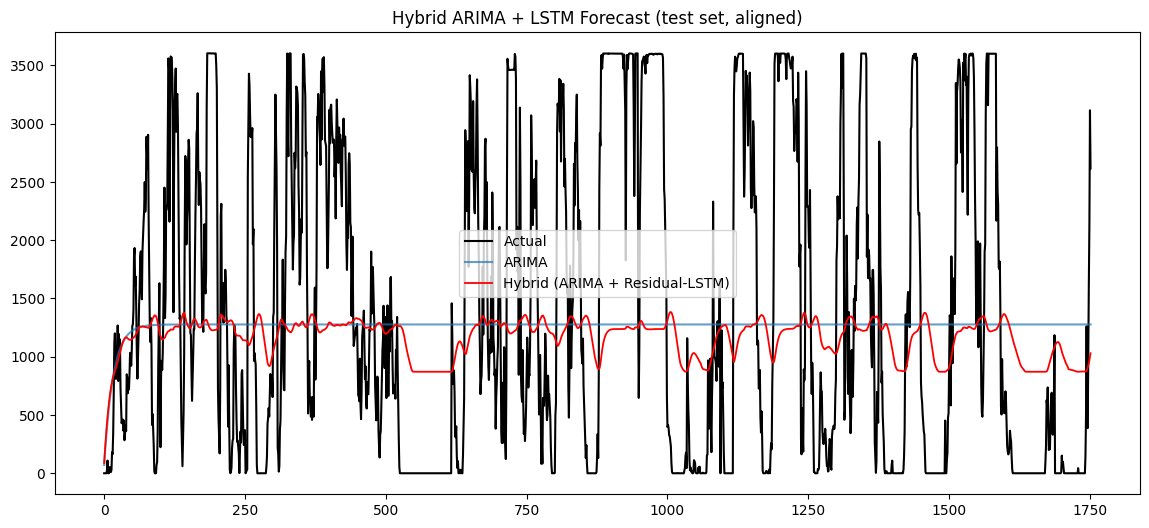

In [1]:
# Hybrid ARIMA + LSTM (full pipeline)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Paths (change if needed)
# ---------------------------
BASE = r"C:\Users\Devra\Wind_energy_prediction"
MODELS_DIR = os.path.join(BASE, "Models")
RESULTS_DIR = os.path.join(BASE, "Results")
DATA_PROCESSED = os.path.join(RESULTS_DIR, "processed_hourly.csv")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# ---------------------------
# 1) Load processed data
# ---------------------------
df = pd.read_csv(DATA_PROCESSED, index_col=0, parse_dates=True)
# target series used in ARIMA
target_col = "ActivePower_kW"   # adjust if different
ts = df[target_col].astype(float)

# Train/test split (same as ARIMA)
split = int(len(ts) * 0.8)
train_ts = ts[:split]
test_ts  = ts[split:]

print(f"Loaded processed data: {df.shape}, train={len(train_ts)}, test={len(test_ts)}")

# ---------------------------
# 2) Load saved ARIMA model and get ARIMA forecasts for test set
# ---------------------------
arima_path = os.path.join(MODELS_DIR, "arima_model.pkl")
if not os.path.exists(arima_path):
    raise FileNotFoundError(f"ARIMA model file not found: {arima_path}")

arima_model = joblib.load(arima_path)
# Forecast for the entire test set
# Depending on how arima_model was saved, use forecast/predict
try:
    arima_pred = arima_model.forecast(steps=len(test_ts))
except Exception:
    # fallback to get_forecast/predictions
    arima_pred = arima_model.predict(start=test_ts.index[0], end=test_ts.index[-1])

# Ensure alignment and convert to pandas Series with test index
arima_pred = pd.Series(arima_pred, index=test_ts.index).astype(float)

# ---------------------------
# 3) Compute residuals (actual - arima_pred)
# ---------------------------
residuals = test_ts - arima_pred
# drop any NaNs if arise
residuals = residuals.dropna()
# Also align arima_pred and test to residuals index
arima_pred = arima_pred.loc[residuals.index]
test_ts_aligned = test_ts.loc[residuals.index]

print("ARIMA predictions and residuals prepared. Residuals length:", len(residuals))

# ---------------------------
# 4) Prepare residual sequences for LSTM
# ---------------------------
# scale residuals to [-1,1] or [0,1] using MinMaxScaler
scaler_res = MinMaxScaler(feature_range=(0,1))
res_scaled = scaler_res.fit_transform(residuals.values.reshape(-1,1))

# sequence length (look-back). Use same logic as your other LSTM; 24 (hours) is common.
SEQ_LEN = 24

def create_sequences(series_scaled, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(seq_len, len(series_scaled)):
        X.append(series_scaled[i-seq_len:i, 0])
        y.append(series_scaled[i, 0])
    return np.array(X), np.array(y)

X_res, y_res = create_sequences(res_scaled, SEQ_LEN)
# reshape to [samples, timesteps, features]
X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))

# Use the last portion for validation (we'll train on whole available train-residuals)
# But here residuals are only for test set; we will train on the **residuals time-series** by
# combining small warm-up: option A: train LSTM on residuals derived from train data as well.
# Simpler robust approach: recompute residuals on full series using in-sample ARIMA predictions.
# Below we'll create residual series from entire series for training LSTM, then predict test residuals.

# ---------------------------
# 4a) Create residuals for whole series (train+test) using ARIMA in-sample prediction
# ---------------------------
# Predict in-sample (fittedvalues) for the part ARIMA was trained on and get in-sample residuals.
# Some ARIMA objects expose 'fittedvalues'; we'll derive fitted on train only:
try:
    fitted_train = arima_model.predict(start=train_ts.index[0], end=train_ts.index[-1])
    fitted_train = pd.Series(fitted_train, index=train_ts.index).astype(float)
    residuals_full_train = train_ts - fitted_train
    # Combine residuals for training: use residuals from train
    residuals_for_training = residuals_full_train.dropna()
    print("Using in-sample residuals from train for LSTM training. Length:", len(residuals_for_training))
except Exception:
    # If cannot compute fitted_train, fall back to using test residuals only (will still train, but small)
    residuals_for_training = residuals.copy()
    print("Could not compute fitted in-sample residuals; using test residuals for training. Length:", len(residuals_for_training))

# Build scaled training residual sequences
res_train_scaled = scaler_res.fit_transform(residuals_for_training.values.reshape(-1,1))
X_train_res, y_train_res = create_sequences(res_train_scaled, SEQ_LEN)
X_train_res = X_train_res.reshape((X_train_res.shape[0], X_train_res.shape[1], 1))

# For prediction on the test residuals, we need sequences built from the end of residuals_for_training
# and then step through to forecast the required number of points equal to len(residuals)
# Simpler: build X_test_res by using the last contiguous sequences from scaled combined series:
combined_scaled = np.concatenate([res_train_scaled, res_scaled], axis=0)
# Build sequences starting at position len(res_train_scaled) (first test residual prediction)
X_comb, y_comb = create_sequences(combined_scaled, SEQ_LEN)
# Determine index where test residuals sequences start:
start_idx = len(res_train_scaled) - SEQ_LEN
X_test_res = X_comb[start_idx:start_idx + len(residuals)]
X_test_res = X_test_res.reshape((X_test_res.shape[0], X_test_res.shape[1], 1))

print("LSTM residual training samples:", X_train_res.shape, "LSTM residual test samples:", X_test_res.shape)

# ---------------------------
# 5) Build and train LSTM on residuals
# ---------------------------
tf.random.set_seed(42)
model_res = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(1)
])
model_res.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)
history = model_res.fit(X_train_res, y_train_res, epochs=50, batch_size=32, callbacks=[es], verbose=1)

# ---------------------------
# 6) Predict residuals for test set and inverse scale
# ---------------------------
res_pred_scaled = model_res.predict(X_test_res)
res_pred = scaler_res.inverse_transform(res_pred_scaled).flatten()

# Align lengths (ensure same length as residuals)
res_pred = res_pred[:len(residuals)]
arima_pred_aligned = arima_pred.loc[residuals.index].values
test_actual_aligned = test_ts.loc[residuals.index].values

# ---------------------------
# 7) Hybrid forecast = ARIMA + predicted residuals
# ---------------------------
hybrid_pred = arima_pred_aligned + res_pred

# ---------------------------
# 8) Evaluate
# ---------------------------
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

mae_ar, rmse_ar, mape_ar, r2_ar = metrics(test_actual_aligned, arima_pred_aligned)
mae_lstm_res, rmse_lstm_res, mape_lstm_res, r2_lstm_res = metrics(test_actual_aligned, arima_pred_aligned + (residuals.values[:len(residuals)]*0))  # baseline
mae_h, rmse_h, mape_h, r2_h = metrics(test_actual_aligned, hybrid_pred)

print("\nModel performance on test (aligned):")
print(f"ARIMA -> MAE: {mae_ar:.3f}, RMSE: {rmse_ar:.3f}, MAPE: {mape_ar:.2f}%, R2: {r2_ar:.3f}")
print(f"Hybrid -> MAE: {mae_h:.3f}, RMSE: {rmse_h:.3f}, MAPE: {mape_h:.2f}%, R2: {r2_h:.3f}")

# ---------------------------
# 9) Save outputs: hybrid forecast, residual model, scaler
# ---------------------------
np.save(os.path.join(RESULTS_DIR, "hybrid_forecast.npy"), hybrid_pred)
np.save(os.path.join(RESULTS_DIR, "hybrid_test_actual.npy"), test_actual_aligned)
model_res.save(os.path.join(MODELS_DIR, "residual_lstm_model.h5"))
joblib.dump(scaler_res, os.path.join(MODELS_DIR, "scaler_residuals.pkl"))

print("\n✅ Hybrid forecast and residual-LSTM model saved:")
print(" -", os.path.join(RESULTS_DIR, "hybrid_forecast.npy"))
print(" -", os.path.join(MODELS_DIR, "residual_lstm_model.h5"))
print(" -", os.path.join(MODELS_DIR, "scaler_residuals.pkl"))

# ---------------------------
# 10) Plot results
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(test_actual_aligned, label="Actual", color='black')
plt.plot(arima_pred_aligned, label="ARIMA", alpha=0.7)
plt.plot(hybrid_pred, label="Hybrid (ARIMA + Residual-LSTM)", color='red', linewidth=1.3)
plt.title("Hybrid ARIMA + LSTM Forecast (test set, aligned)")
plt.legend()
plt.show()
